In [1]:
%matplotlib inline
from sys import path
path.append('/home/rui/blacksid/mew-p')
DATA_PATH = '/home/rui/blacksid/data/dockfuture'
import numpy as np
import pytz
from datetime import datetime
import cProfile
import matplotlib.pyplot as plt
from mewp.data.item import Contract
from mewp.simulate.wrapper import TrendAlgoWrapper
from mewp.simulate.runner import SingleRunner
import pandas as pd
from mewp.util.clock import Clock
from mewp.util.candle import Candle
from mewp.util.candle import CandleCreator
from mewp.util.candle import CandleAnalysis

In [2]:
product = 'cu'
data = pd.read_csv('/home/rui/blacksid/data/adjusted_daily/{}0.csv'.format(product.upper()))
candles = []
for row in data.iterrows():
    time1 = datetime.strptime(row[1].datetime+'-09', '%Y-%m-%d-%H')
    time2 = datetime.strptime(row[1].datetime+'-21', '%Y-%m-%d-%H')
    start_time = int((time1 - datetime(1970, 1, 1)).total_seconds() * 1000)
    end_time = int((time2 - datetime(1970, 1, 1)).total_seconds() * 1000)
    day_info = {}
    day_info['HighPrice'] = row[1].HighPx
    day_info['LowPrice'] = row[1].LowPx
    day_info['OpenPrice'] = row[1].OpeningPx
    day_info['ClosePrice'] = row[1].ClosingPx
    day_info['Volume'] = row[1].TotalVolumeTraded
    day_info['SettlePrice'] = row[1].SettlPx
    day_info['Position'] = row[1].OpenInterest
    day_info['LastPosition'] = 0
    temp_candle = Candle(day_info, start_time, end_time)
    candles.append(temp_candle)

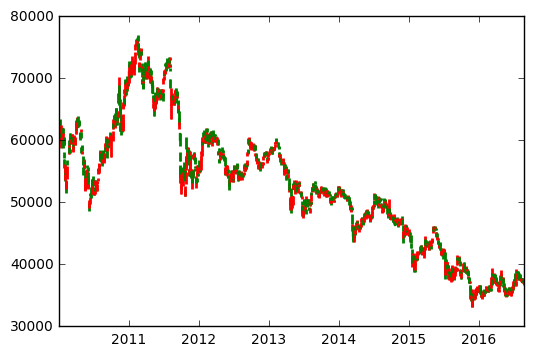

In [5]:
%matplotlib inline
for candle in candles:
    candle.plot_candle()

In [6]:
contract = Contract(product)

In [8]:
contract.fee_perhand
contract.units

5e-05

In [ ]:
temp_candle.close_price

In [18]:
date = datetime.fromtimestamp(temp_candle.start_time/1000)
str(date.date())

'2016-08-24'

In [2]:
class AlgoBase(object):
    def __init__(self, product):
        self.contract = Contract(product)
        self.pos = 0
        self.cash = 0
        self.pnl_history = []
    
    def _long(self, qty, price):
        self.pos += qty
        self.cash -= qty * price * self.contract.units
        self.cash -= qty * price * self.contract.units * self.contract.fee_peramount
        self.cash -= qty * self.contract.fee_perhand        
    
    def _short(self, qty, price):
        self.pos -= qty
        self.cash += qty * price * self.contract.units
        self.cash -= qty * price * self.contract.units * self.contract.fee_peramount
        self.cash -= qty * self.contract.fee_perhand
    
    def _order_to(self, qty, price):
        if qty == self.pos:
            return
        elif qty>self.pos:
            self._long(qty-self.pos, price)
        else:
            self._short(self.pos - qty, price)
            
    def on_candle(self, candle, next_open_price):
        pass

In [78]:
param = {'ma1':10, 'ma2':50, 'filter1':50, 'filter2':100, 'atr_stop_loss': 200, 'alpha': 0.1, 'hands': 1}

In [79]:
candle.start_time

1472029200000L

In [80]:
class ATR(object):
    ## Constructor
    # @param alpha for ema
    def __init__(self, alpha):
        self.alpha = alpha
        # computed
        self.mean = 0
        
    ## add a new observation, and refresh
    def add(self, observe):
        if (self.mean == 0):
            self.mean = observe
        else:
            self.mean = self.mean + self.alpha * (observe - self.mean)

class MACross(AlgoBase):
    def __init__(self, product, param):
        super(MACross, self).__init__(product)
        self.pre_close_price = []
        self.param = param
        self.atr = ATR(self.param['alpha'])
        self.trade_day_list = []
        self.window = max(self.param['ma2'], self.param['filter2'])
        self.pre_cross = None
        self.pre_high = None
        self.pre_low = None
        
    
    def buy_filter(self):
        if np.mean(self.pre_close_price[-self.param['filter1']:]) >\
            np.mean(self.pre_close_price[-self.param['filter2']:]):
            return True
        else:
            return False
    
    def sell_filter(self):
        if np.mean(self.pre_close_price[-self.param['filter1']:]) <\
            np.mean(self.pre_close_price[-self.param['filter2']:]):
            return True
        else:
            return False
                
    
    def on_candle(self, candle, next_open_price):
        date = datetime.fromtimestamp(candle.start_time/1000)
        date_str = str(date.date())
        self.trade_day_list.append(date_str)
        self.pre_close_price.append(candle.close_price)
        if len(self.pre_close_price) > 1:
            TR = max(self.pre_close_price[-2], candle.high) - min(self.pre_close_price[-2], candle.low)
            self.atr.add(TR)
        if len(self.pre_close_price) < self.window:
            self.pnl_history.append(0)
            return
        if self.pre_cross == None:
            if np.mean(self.pre_close_price[-self.param['ma1']:]) >\
                np.mean(self.pre_close_price[-self.param['ma2']:]):
                self.pre_cross = 1
            else:
                self.pre_cross = -1
            self.pnl_history.append(0)
            return
        if np.mean(self.pre_close_price[-self.param['ma1']:]) >\
                np.mean(self.pre_close_price[-self.param['ma2']:]):
            cross = 1
        else:
            cross = -1
        if self.pre_cross == None:
            iself.pre_cross = cross
            self.pnl_history.append(0)
            return
        if cross == 1 and self.pre_cross == -1 and self.buy_filter():
                self._order_to(self.param['hands'], next_open_price)
                self.pre_high = candle.close_price
        elif cross == -1 and self.pre_cross == 1 and self.sell_filter():
                self._order_to(-self.param['hands'], next_open_price)
                self.pre_low = candle.close_price
        # stop_loss 
        if self.pos > 0:
            assert(self.pre_high!=None)
            if candle.close_price > self.pre_high:
                self.pre_high = candle.close_price
            diff = self.pre_high - candle.close_price
            assert(diff>=-1e-6)
            if diff > self.param['atr_stop_loss'] * self.atr.mean:
                self._order_to(0, next_open_price)
                self.pre_high = None
            
        if self.pos < 0:
            assert(self.pre_low!=None)
            if candle.close_price < self.pre_low:
                self.pre_low = candle.close_price
            diff = candle.close_price - self.pre_low
            assert(diff>=-1e-6)
            if diff > self.param['atr_stop_loss'] * self.atr.mean:
                self._order_to(0, next_open_price)
                self.pre_low = None
        self.pre_cross = cross
        pnl = self.pos * next_open_price * self.contract.units + self.cash
        
        self.pnl_history.append(pnl)

In [206]:
param = {'ma1':5, 'ma2':50, 'filter1':50, 'filter2':200, 'atr_stop_loss': 2, 'alpha': 0.1, 'hands': 1}

In [207]:
cuAccount = MACross('cu',param)

In [208]:
for i in range(len(candles)-1):
    cuAccount.on_candle(candles[i], candles[i+1].open_price)

In [209]:
cuAccount.pnl_history[-1]

66667.80249999993

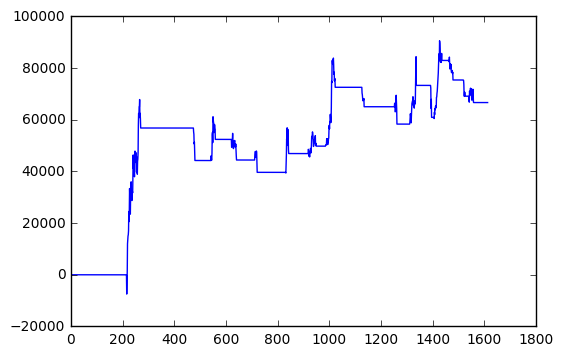

In [210]:
plt.plot(cuAccount.pnl_history)

In [175]:
len(candles)

1615

137311.18596


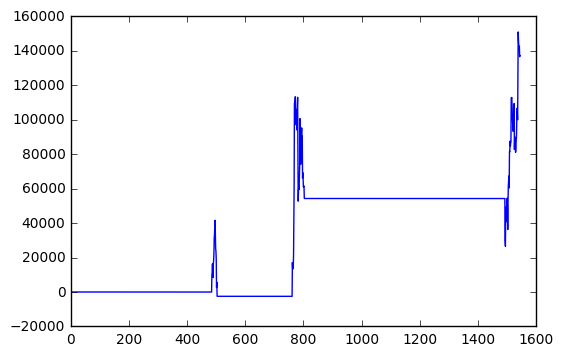

In [237]:
product = 'if'
data = pd.read_csv('/home/rui/blacksid/data/adjusted_daily/{}0.csv'.format(product.upper()))
candles = []
for row in data.iterrows():
    time1 = datetime.strptime(row[1].datetime+'-09', '%Y-%m-%d-%H')
    time2 = datetime.strptime(row[1].datetime+'-21', '%Y-%m-%d-%H')
    start_time = int((time1 - datetime(1970, 1, 1)).total_seconds() * 1000)
    end_time = int((time2 - datetime(1970, 1, 1)).total_seconds() * 1000)
    day_info = {}
    day_info['HighPrice'] = row[1].HighPx
    day_info['LowPrice'] = row[1].LowPx
    day_info['OpenPrice'] = row[1].OpeningPx
    day_info['ClosePrice'] = row[1].ClosingPx
    day_info['Volume'] = row[1].TotalVolumeTraded
    day_info['SettlePrice'] = row[1].SettlPx
    day_info['Position'] = row[1].OpenInterest
    day_info['LastPosition'] = 0
    temp_candle = Candle(day_info, start_time, end_time)
    candles.append(temp_candle)
param = {'ma1':10, 'ma2':100, 'filter1':50, 'filter2':100, 'atr_stop_loss': 3, 'alpha': 0.1, 'hands': 1}
cuAccount = MACross(product,param)
for i in range(len(candles)-1):
    cuAccount.on_candle(candles[i], candles[i+1].open_price)
print cuAccount.pnl_history[-1]
plt.plot(cuAccount.pnl_history)

In [11]:
class ATR(object):
    ## Constructor
    # @param alpha for ema
    def __init__(self, alpha):
        self.alpha = alpha
        # computed
        self.mean = 0
        
    ## add a new observation, and refresh
    def add(self, observe):
        if (self.mean == 0):
            self.mean = observe
        else:
            self.mean = self.mean + self.alpha * (observe - self.mean)

class BreakOut(AlgoBase):
    def __init__(self, product, param):
        super(BreakOut, self).__init__(product)
        self.pre_close_price = []
        self.param = param
        self.atr = ATR(self.param['alpha'])
        self.trade_day_list = []
        self.window = max(self.param['breakout_window'], self.param['filter2'])
        self.pre_high = None
        self.pre_low = None
        
    
    def buy_filter(self):
        if np.mean(self.pre_close_price[-self.param['filter1']:]) >\
            np.mean(self.pre_close_price[-self.param['filter2']:]):
            return True
        else:
            return False
    
    def sell_filter(self):
        if np.mean(self.pre_close_price[-self.param['filter1']:]) <\
            np.mean(self.pre_close_price[-self.param['filter2']:]):
            return True
        else:
            return False
    
    def buy_signal(self):
        if self.pre_close_price[-1] > np.max(self.pre_close_price[-self.param['breakout_window']-1:-1]):
            return True
        return False
    
    def sell_signal(self):
        if self.pre_close_price[-1] < np.min(self.pre_close_price[-self.param['breakout_window']-1:-1]):
            return True
        return False
    
    def on_candle(self, candle, next_open_price):
        date = datetime.fromtimestamp(candle.start_time/1000)
        date_str = str(date.date())
        self.trade_day_list.append(date_str)
        self.pre_close_price.append(candle.close_price)
        if len(self.pre_close_price) > 1:
            TR = max(self.pre_close_price[-2], candle.high) - min(self.pre_close_price[-2], candle.low)
            self.atr.add(TR)
        if len(self.pre_close_price) < self.window:
            self.pnl_history.append(0)
            return

        if self.buy_signal() and self.buy_filter():
                self._order_to(self.param['hands'], next_open_price)
                self.pre_high = candle.close_price
        elif self.buy_signal() and self.sell_filter():
                self._order_to(-self.param['hands'], next_open_price)
                self.pre_low = candle.close_price
        # stop_loss 
        if self.pos > 0:
            assert(self.pre_high!=None)
            if candle.close_price > self.pre_high:
                self.pre_high = candle.close_price
            diff = self.pre_high - candle.close_price
            assert(diff>=-1e-6)
            if diff > self.param['atr_stop_loss'] * self.atr.mean:
                self._order_to(0, next_open_price)
                self.pre_high = None
            
        if self.pos < 0:
            assert(self.pre_low!=None)
            if candle.close_price < self.pre_low:
                self.pre_low = candle.close_price
            diff = candle.close_price - self.pre_low
            assert(diff>=-1e-6)
            if diff > self.param['atr_stop_loss'] * self.atr.mean:
                self._order_to(0, next_open_price)
                self.pre_low = None
        pnl = self.pos * next_open_price * self.contract.units + self.cash        
        self.pnl_history.append(pnl)

171875.81952


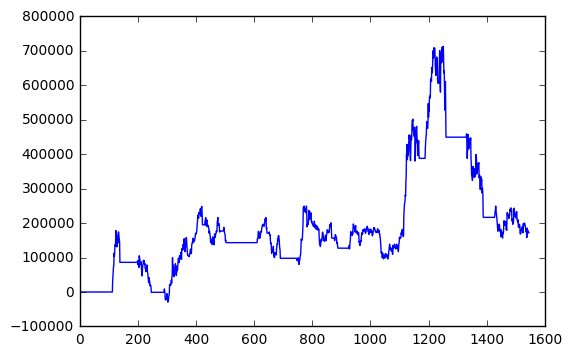

In [14]:
product = 'if'
data = pd.read_csv('/home/rui/blacksid/data/adjusted_daily/{}0.csv'.format(product.upper()))
candles = []
for row in data.iterrows():
    time1 = datetime.strptime(row[1].datetime+'-09', '%Y-%m-%d-%H')
    time2 = datetime.strptime(row[1].datetime+'-21', '%Y-%m-%d-%H')
    start_time = int((time1 - datetime(1970, 1, 1)).total_seconds() * 1000)
    end_time = int((time2 - datetime(1970, 1, 1)).total_seconds() * 1000)
    day_info = {}
    day_info['HighPrice'] = row[1].HighPx
    day_info['LowPrice'] = row[1].LowPx
    day_info['OpenPrice'] = row[1].OpeningPx
    day_info['ClosePrice'] = row[1].ClosingPx
    day_info['Volume'] = row[1].TotalVolumeTraded
    day_info['SettlePrice'] = row[1].SettlPx
    day_info['Position'] = row[1].OpenInterest
    day_info['LastPosition'] = 0
    temp_candle = Candle(day_info, start_time, end_time)
    candles.append(temp_candle)
param = {'breakout_window': 25, 'filter1':50, 'filter2':100, 'atr_stop_loss': 3, 'alpha': 0.1, 'hands': 1}
cuAccount = BreakOut(product,param)
for i in range(len(candles)-1):
    cuAccount.on_candle(candles[i], candles[i+1].open_price)
print cuAccount.pnl_history[-1]
plt.plot(cuAccount.pnl_history)

In [15]:
cuAccount.contract.name

'if'